<a href="https://colab.research.google.com/github/meg-an31/PubTrends-Data-Insights-for-Enhanced-Paper-Relevance/blob/main/colab-file-copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubTrends: Data Insights for Enhanced Paper Relevance

To choose the number of clusters the algorithm uses, please input an integer in the box `num_clusters` below.

Also include the file named `PMIDs_list` before running by going to the left hand menu, and selecting **Files → Upload to session storage**.

To run the code, select **Runtime → Run all**.

The final graph will be displayed at the bottom of the page. *I am so sorry about how long it takes to run! eutils limits the number of API calls you can make without a key (and google colab is also hellishly slow).*

In [4]:
num_clusters = 4 # @param {"type":"integer"}

if num_clusters <= 0:
  raise Exception("Please input a positive integer!")

[2 3 3 3 3 3 1 2 1 1 0 3 3 2 2 0 0 0 0 1 1 1 1 2 1 3 2 3 3 3 2 2 2 2 2 2 3
 2 2 0 2 2 2 2 2 2 1 1 3 3 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3
 1 1 1 1 0 0 0 2 2 1 0 3 0 3 3 1 3 3 3 3 3 1 3 3 3 3 2 2 2 2 1 2 1 1 1 1 3
 3 1 2 1 1 3 2 3 3 3 1 3 3 1 3 2 3 3 3 2 3 3 3 3 3 3 3 3 0 1 3 3 1 3]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10838 stored elements and shape (145, 2614)>
  Coords	Values
  (0, 1390)	0.11205886685132839
  (0, 2533)	0.1923400367103667
  (0, 1662)	0.12715116633401044
  (0, 2233)	0.08167024690203409
  (0, 1772)	0.08482914961738947
  (0, 2212)	0.22133957961666528
  (0, 695)	0.44267915923333057
  (0, 1410)	0.28851005506555005
  (0, 2139)	0.08167024690203409
  (0, 477)	0.041837496738963656
  (0, 2529)	0.11066978980833264
  (0, 2197)	0.04853243705001123
  (0, 2528)	0.44267915923333057
  (0, 488)	0.15001718686688567
  (0, 2132)	0.09150213455496885
  (0, 2362)	0.11066978980833264
  (0, 1394)	0.08768819578606393
  (0, 2222)	0.11066978980833264
  (0, 345

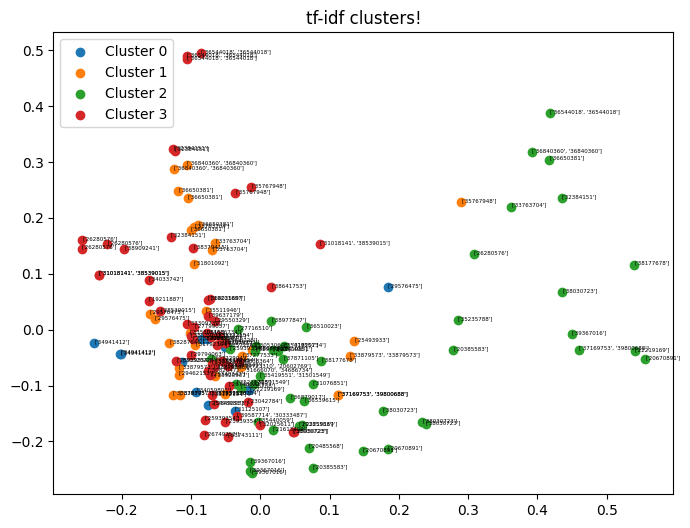

In [5]:
!pip install eutils
from eutils import QueryService
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
import xml.etree.ElementTree as et
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

qs = QueryService()

with open('PMIDs_list.txt') as file:
    pmids = [line.rstrip() for line in file]
#pmids = ['30530648', '31820734']

def fetchAllDBIDs():
    all_ids = {}
    for pmid in pmids:
        # using the eutils library to get the xml doc containing db ids
        xml = qs.elink({'db':'gds', 'dbfrom':'pubmed', 'id':pmid})
        # converting to a xml tree
        root = et.ElementTree(et.fromstring(xml)).getroot()
        # getting all database links contained within the database linkset
        for db in list(root.iter('Link')):
            dbid_temp = list(db.iter('Id'))[0].text
            if not(dbid_temp in list(all_ids.keys())):
                all_ids[dbid_temp] = []
            all_ids[dbid_temp].append(str(pmid))
            #print(dbid_temp)
    return all_ids

def fetchAllDescriptions(dbIDs):
    out = []
    for dbID in dbIDs:
      try:
          out.append((str(qs.efetch({'db':'gds', 'id':dbID,}))
                      .replace('\\n',' ').replace('\\t',' ').replace('more...',' ')
                      .replace('(Submitter supplied)',' ').replace('Organism:',' ').replace('Type:',' ').split(
              'Platforms:'))[0])
      except:
          print(f"ERROR: Could not find database with id {dbID}")
        #print(out[-1])
    return out

def main():
    # here I am not using an API key, which limits me to 3 requests/second
    allDBIDs = fetchAllDBIDs()
    allDBdescriptions = fetchAllDescriptions(list(allDBIDs.keys()))
    vectoriser = TfidfVectorizer()
    # X is the matrix of all words and their tf-idf values
    X = vectoriser.fit_transform(allDBdescriptions)
    distances = cosine_distances(X)
    # we now have that distances[a][b] gives the distance between database a and b
    # num_clusters is defined above as the user input!
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Labels indicate which cluster each description belongs to
    labels = kmeans.labels_
    print(labels)
    print(X)
    print(vectoriser.get_feature_names_out())

    # in order to visualise what is happening, I flatten the points onto a 2d plane,
    # using the pca algorithm
    pca = PCA(n_components=2)
    points_2d = pca.fit_transform(X.toarray())

    plt.figure(figsize=(8, 6))
    for i in range(num_clusters):
        points = points_2d[labels == i]
        plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

    plt.title("tf-idf clusters!")
    plt.legend()
    for i, (x, y) in enumerate(points_2d):
        plt.text(x, y, str(list(allDBIDs.values())[i]), fontsize=4)
    plt.show()

if __name__ == '__main__':
    main()